## Load the Google Drive

In [3]:
!ls

datalab  sample_data


In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [6]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

## Importing the packages

In [0]:
!pip install fastai
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image
!pip install pydicom
%matplotlib inline
#!git clone https://github.com/pytorch/text
#!python text/setup.py install --force

In [0]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
# This file contains all the main external libs we'll use
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
import os
import h5py

In [20]:
# Download the necessary files from my repo
!wget "https://raw.githubusercontent.com/isados/breast-cancer-screening/fastai/utility.py"
!wget --header="Host: media.githubusercontent.com" --header="User-Agent: Mozilla/5.0 (Macintosh; Intel Mac OS X 10_12_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/68.0.3440.106 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8" --header="Accept-Language: en-US,en;q=0.9,ar;q=0.8,es;q=0.7" "https://media.githubusercontent.com/media/isados/breast-cancer-screening/fastai/data/images_1227.hdf5" -O "images_1227.hdf5" -c
!mkdir -p data
!mv images_1227.hdf5 data/

--2018-08-24 13:38:44--  https://raw.githubusercontent.com/isados/breast-cancer-screening/fastai/utility.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 967 [text/plain]
Saving to: ‘utility.py’

utility.py          100%[===================>]     967  --.-KB/s    in 0s      

2018-08-24 13:38:44 (91.1 MB/s) - ‘utility.py’ saved [967/967]

--2018-08-24 13:38:46--  https://media.githubusercontent.com/media/isados/breast-cancer-screening/fastai/data/images_1227.hdf5
Resolving media.githubusercontent.com (media.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to media.githubusercontent.com (media.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 219405953 (209M) [ap

## The Start

In [13]:
PATH = "data/"
sz=224
torch.cuda.is_available()

True

In [14]:
torch.backends.cudnn.enabled

True

## Load and Display images

In [15]:
with h5py.File(PATH+"images_1227.hdf5", "r") as f:
    b=f['benign']
    img_b=b['images'][...].astype(np.float32)
#    lbl_b=b['labels'][...]
    m=f['malignant']
    img_m=m['images'][...].astype(np.float32)
#    lbl_m=m['labels'][...]

# BENIGN : 0 , MALIGNANT : 1
lbl_b=np.zeros((img_b.shape[0],),dtype=np.int8)
lbl_m=np.ones((img_m.shape[0],),dtype=np.int8)
print(img_m.dtype,img_m.shape)

float32 (599, 89401)


In [16]:
lbl_b.dtype

dtype('int8')

[26325. 26868. 27369. ... 31926. 32449. 33231.]


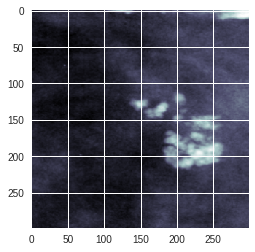

In [17]:
plt.imshow(img_b[2].reshape((299,299)),cmap=plt.cm.bone)
print(img_b[2])

## Prepare Training and Test Sets

In [0]:
# Reshaping each Image array and creating an axis for the 3 channels
img_b=img_b.reshape((-1,299,299))
img_b=img_b[...,None].repeat(3,axis=3)

img_m=img_m.reshape((-1,299,299))
img_m=img_m[...,None].repeat(3,axis=3)

In [0]:
""" Not required """
# # Splitting the dataset into equal number of samples for both classes; and then create the validation set
# img_b,img_m,=[],[]
# for index,label in enumerate(lbl):
#     image=img[index]
#     if label==b'BENIGN':
#         img_b.append(image)
#     else:
#         img_m.append(image)
# img_b=np.array(img_b)
# img_m=np.array(img_m)

In [23]:
from utility import *
split=0.8

# Returns train-test split for BENIGN cases 
imgb_trn,imgb_tst=return_trn_test_split(data=img_b,frac=split)
lblb_trn,lblb_tst=return_trn_test_split(data=lbl_b,frac=split)

# Returns train-test split for MALIGNANT cases  
imgm_trn,imgm_tst=return_trn_test_split(data=img_m,frac=split)
lblm_trn,lblm_tst=return_trn_test_split(data=lbl_m,frac=split)

# Prepare Labels for training set
lbl_trn=np.concatenate([lblb_trn,lblm_trn])

# Prepare Labels for test set
lbl_tst=np.concatenate([lblb_tst,lblm_tst])

# Prepare images for Training set
img_trn=np.vstack([imgb_trn,imgm_trn])

# Prepare images for Test set
img_tst=np.vstack([imgb_tst,imgm_tst])

print("Train Set Size: {}\tTest Set Size: {}".format(lbl_trn.shape[0],lbl_tst.shape[0]))
print(img_trn.shape,"\t",img_tst.shape)

Train Set Size: 981	Test Set Size: 246
(981, 299, 299, 3) 	 (246, 299, 299, 3)


In [0]:
# Final Tuple
trn,tst=(img_trn,lbl_trn),(img_tst,lbl_tst)

## Initial Model

In [0]:
arch=resnet34
labels=['BENIGN','MALIGNANT']
data = ImageClassifierData.from_arrays(PATH, trn=trn,val=tst,classes=labels,tfms=tfms_from_model(arch, sz),bs=40)
learn = ConvLearner.pretrained(arch, data, precompute=True)
# Find the best learning rate
#lrf=learn.lr_find()

In [33]:
lrf=learn.lr_find()

 63%|██████▎   | 155/246 [00:01<00:01, 85.02it/s, loss=3.57]


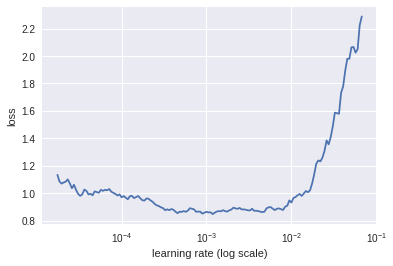

In [34]:
learn.sched.plot()

In [78]:
# Fit once
learn.fit(0.005, 2)

epoch      trn_loss   val_loss   accuracy   
    0      0.894401   7.41842    0.560976  
    1      0.824248   8.133109   0.617886  


[array([8.13311]), 0.6178861827385135]

In [0]:
learn.precompute=False

In [81]:
# Fit again
learn.fit(0.01, 10, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.685386   0.672341   0.601626  
    1      0.673697   0.691114   0.565041  
    2      0.678395   0.674862   0.589431  
    3      0.682753   0.681794   0.613821  
    4      0.690829   0.71015    0.581301  
    5      0.67675    0.682959   0.597561  
    6      0.689676   0.707145   0.593496  
    7      0.677265   0.701033   0.601626  
    8      0.674036   0.711952   0.589431  
    9      0.673885   0.68968    0.601626  
    10     0.677192   0.666972   0.601626  
    11     0.671674   0.659079   0.609756  
    12     0.667189   0.685942   0.581301  
    13     0.662796   0.650225   0.630081  
    14     0.674036   0.676439   0.626016  
    15     0.666826   0.689965   0.581301  
    16     0.660935   0.729013   0.589431  
    17     0.656197   0.688497   0.589431  
    18     0.6684     0.656286   0.626016  
    19     0.650739   0.670518   0.565041  


[array([0.67052]), 0.5650406460451886]

In [0]:
tfms = tfms_from_model(arch, 299, aug_tfms=transforms_side_on, max_zoom=1.1)
#tfms=tfms_from_model(arch, sz)
data = ImageClassifierData.from_arrays(PATH, trn=trn,val=tst,classes=labels,tfms=tfms,bs=40)
learn.set_data(data)
learn.precompute=True
#learn.unfreeze()
alpha=0.0005
#lr=[alpha/100,alpha,alpha]

In [100]:
# Fit again
learn.fit(alpha, 10, cycle_len=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.553808   0.664899   0.617886  
    1      0.556877   0.67081    0.626016  
    2      0.566571   0.666882   0.621951  
    3      0.569681   0.672803   0.621951  
    4      0.565559   0.670667   0.634146  
    5      0.564286   0.669648   0.634146  
    6      0.565311   0.672074   0.634146  
    7      0.568369   0.666178   0.638211  
    8      0.568891   0.67016    0.613821  
    9      0.567918   0.672072   0.621951  
    10     0.574661   0.667939   0.634146  
    11     0.563077   0.665665   0.630081  
    12     0.561644   0.672359   0.626016  
    13     0.575238   0.67946    0.626016  
    14     0.567123   0.66149    0.630081  
    15     0.554573   0.669029   0.621951  
    16     0.552813   0.689057   0.605691  
    17     0.546063   0.670692   0.630081  
    18     0.548359   0.657332   0.626016  
    19     0.555695   0.666115   0.630081  


[array([0.66611]), 0.6300813022667799]

In [0]:
#learn.save('initial')
!mkdir -p drive/models/cancer
!cp data/models/* drive/models/cancer

## Change size of Image

In [0]:
# Run this only when initialising the model
arch=resnet34
tfms = tfms_from_model(arch, 299, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms,trn_name='training',val_name='validation')
learn = ConvLearner.pretrained(arch, data, precompute=False)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /content/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:00<00:00, 97662408.45it/s]


In [0]:
tfms = tfms_from_model(arch, 299, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms,trn_name='training',val_name='validation')
learn.set_data(data)
learn.freeze()

In [0]:
learn.fit(1e-2, 3, cycle_len=1)

epoch      trn_loss   val_loss   accuracy   
    0      0.164723   0.092937   0.977941  
    1      0.170718   0.075668   0.985294  
    2      0.164526   0.067321   0.981618  



[array([0.06732]), 0.9816176470588235]

In [0]:
# When you are under fitting, it means cycle_len=1 is too short (learning rate is getting reset before it had the chance to zoom in properly).
learn.fit(1e-2, 3, cycle_len=1, cycle_mult=2) # 1+2+4 = 7 epochs

epoch      trn_loss   val_loss   accuracy   
    0      0.140643   0.066152   0.977941  
    1      0.152788   0.059445   0.981618  
    2      0.138595   0.057111   0.977941  
    3      0.138765   0.049833   0.985294  
    4      0.130745   0.045633   0.985294  
    5      0.121055   0.045036   0.988971  
    6      0.117725   0.043676   0.988971  



[array([0.04368]), 0.9889705882352942]

In [0]:
learn.save('299')


In [0]:
!mkdir drive/models/monkeys
!cp monkeys/models/* drive/models/monkeys

In [0]:
learn.fit(0.04, 3, cycle_len=1, cycle_mult=2)

epoch      trn_loss   val_loss   accuracy   
    0      0.098369   0.043427   0.988971  
    1      0.093829   0.037283   0.988971  
    2      0.103249   0.035257   0.992647  
    3      0.093968   0.029273   0.992647  
    4      0.095776   0.024333   0.996324  
    5      0.088497   0.024106   0.996324  
    6      0.079947   0.024375   0.996324  



[array([0.02437]), 0.9963235294117647]

In [0]:
learn.save('299_im')
!cp monkeys/models/299_im.h5 drive/models/monkeys

In [0]:
!cp drive/models/monkeys/* monkeys/models/
!ls monkeys/models

224.h5	299.h5	299_im.h5  tmp.h5


In [0]:
log_preds, y = learn.TTA() # (5, 2044, 120), (2044,)
probs = np.mean(np.exp(log_preds),0)
accuracy_np(probs, y), metrics.log_loss(y, probs)

(0.9926470588235294, 0.024276230360895577)

In [0]:
probs.shape

(272, 10)

In [0]:
learn.load('299_im')
learn.precompute=False
#learn.unfreeze()
#lr=0.04


In [0]:
learn.fit([lr/100,lr/10,lr],1)

epoch      trn_loss   val_loss   accuracy   
    0      0.037509   0.025447   0.988971  


[array([0.02545]), 0.9889705882352942]

## Individual Prediction

In [0]:
data.classes

['n0', 'n1', 'n2', 'n3', 'n4', 'n5', 'n6', 'n7', 'n8', 'n9']

In [0]:
df=pd.read_csv(f'{PATH}monkey_labels.csv',sep=',')
files = os.listdir(f'{PATH}validation/n6')
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata,mantled_howler,131,26
1,n1,erythrocebus_patas,patas_monkey,139,28
2,n2,cacajao_calvus,bald_uakari,137,27
3,n3,macaca_fuscata,japanese_macaque,152,30
4,n4,cebuella_pygmea,pygmy_marmoset,131,26
5,n5,cebus_capucinus,white_headed_capuchin,141,28
6,n6,mico_argentatus,silvery_marmoset,132,26
7,n7,saimiri_sciureus,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


[[-8.47415 -5.3419  -8.98657 -7.33615 -8.40222 -4.85955 -0.01505 -7.9327  -7.99449 -7.61879]]
6    silvery_marmoset
Name: Common Name, dtype: object


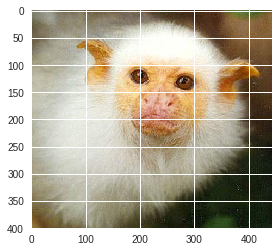

In [0]:
#learn.load('299_im')
img=open_image(f'{PATH}validation/n6/{files[7]}')
plt.imshow(img)
img=tfms[1](img)
preds=learn.predict_array(img[None])
print(preds)
print(df[df.Label==data.classes[np.argmax(preds)]]['Common Name'])

In [0]:
img=plt.imread(f'{PATH}validation/n4/{files[5]}')
print(img.shape)
#img=tfms[1](img)

plt.imshow(img)
#tfms

(550, 700, 3)


In [0]:
fn=f'validation/n4/{files[7]}'
trn_tfms, val_tfms = tfms_from_model(arch, sz)
ds = FilesIndexArrayDataset([fn], np.array([0]), val_tfms, PATH)
dl = DataLoader(ds)
preds = learn.predict_dl(dl)
np.argmax(preds)

4